# Custom Model Development Using TensorFlow

<b><i>Hola!! Welcome Back to my notebook, if you are new here, leave a comment as shout out.
    </i></b>

### 1. So whats the deal here?

<b><i>I am learning how  to build custom models from scratch using lower level API's of TensorFlow.</i></b>

<i>So I will try to implementing every aspect of a simple Multi Layer Perceptron (MLP) using custom build functions and classes.</i>

### 2. Why Do It?

<b><ul>
    <li>Cause at Industrial Level,you need to implement custom tools, for unique problems</li>
    <li>Learning to code custom models, leads to learning custom GPU optimizations, and thats awesome!</li>
    <li>Other way is too easy, and too boring</li>

### 2. Whats Already Completed

<b><ol>
    <li>Data loading, processing into Tensors</li>
    <li>Sampling & Visualizing Images</li>
    <li>Designing & Implementing Normalization Class</li>
    <li>Define Custom Kernel Initializer</li>
    <li>Define Custom Activation Functions</li>
    <li>Designing & Implementing Custom Dense Layer</li>
    <li>Build Custom Model, with number of layers & units as hyper parameters</li>
    </ol></b>

### 3. Whats Yet to be Done

<b><ol>
    <li>Building Custome Layer to Implement Flattening</li>
    <li>Build Custom Implementation of Loss 'Ndam'</li>
    <li>Build Custom Implementation of Optimizer 'Sparse Categorical Cross Entropy'</li>
    <li>Build Custom Implementations of All major Layer types, CNN, LSTM, RNN, etc.</li>
</ol></b>

In [180]:
# Load Libraries
import tensorflow as tf
import tensorflow.keras as keras
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Define Work Space
work_dir = os.curdir
data_dir = os.path.join(work_dir,'datasets')
log_dir = os.path.join(work_dir,'logs')

In [3]:
def LoadData(): # Load the Data and convert them to tensors
    (X_train,y_train),(X_test,y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')
    X_train = tf.constant(X_train,dtype='float32')
    X_test = tf.constant(X_test,dtype='float32')
    y_train = tf.constant(y_train,dtype='float32')
    y_test = tf.constant(y_test,dtype='float32')
    return ((X_train,y_train),(X_test,y_test))

In [4]:
(X_train,y_train),(X_test,y_test) = LoadData()

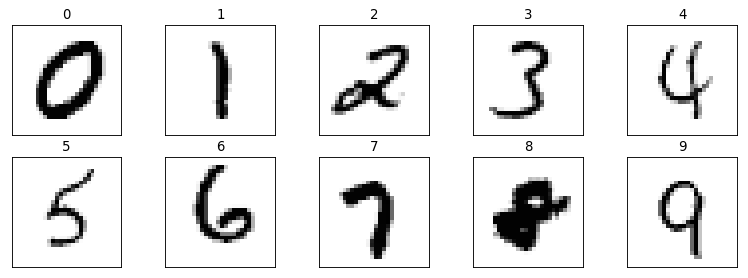

In [5]:
# Sample & Visualize Images
fig,ax = plt.subplots(nrows=2,ncols=5,figsize=(12,4),dpi=80)
for i in range(2):
    for j in range(5):
        dig = i*5 + j
        bool_list = (y_train == dig)
        idx = np.random.randint(low=0,high=1000)
        X_sample = X_train[bool_list][idx]
        y_sample = y_train[bool_list][idx]
        ax[i][j].imshow(np.array(X_sample),cmap='Greys')
        ax[i][j].title.set_text(dig)
        ax[i][j].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
        ax[i][j].tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

## Custom Normalization Layer

In [6]:
# Custom Implementation of Normalization Layer
class MyNormalizationLayer(tf.keras.layers.Layer):
    def __init__(self,epsilon=0.0001,**kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon
        
    def build(self,batch_input_shape):
        self.alpha = tf.Variable(np.ones(shape=batch_input_shape[-1:]),dtype='float32')
        self.beta = tf.Variable(np.zeros(shape=batch_input_shape[-1:]),dtype='float32')
    
    def call(self,inputs):
        if len(inputs.shape) == 1:
            mu,var = tf.nn.moments(inputs, axes=0, keepdims=True)
        else:
            mu,var = tf.nn.moments(inputs, axes=1, keepdims=True)
        std = tf.math.sqrt(var)
        return self.alpha*(inputs-mu)/(std + self.epsilon) + self.beta
    
    def compute_output_shape(self,batch_input_shape):
        return batch_input_shape
    
    def get_config():
        base_config =super().get_config()
        return {**base_config,'epsilon':self.epsilon}

## Custom Kernel Initializers

In [171]:
def my_glorot_normal(shape,dtype=tf.float32,seed=42): # Custom Implementation of Kernel Initialization function
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape=shape,stddev=stddev,seed=seed)

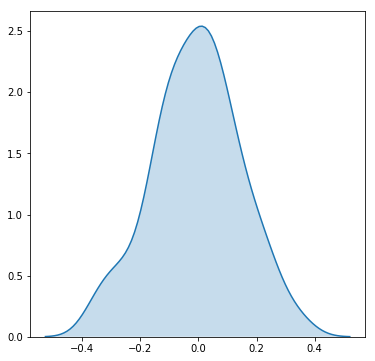

In [187]:
fig,ax = plt.subplots(figsize=(6,6))
kernel_init_weights = my_glorot_normal((100,1))
sns.kdeplot(kernel_init_weights.numpy().reshape(1,-1)[0],shade=True)

## Custom Activation Functions

In [198]:
def my_relu(z): # Custom Relu Activation Function
    return tf.cast(tf.nn.leaky_relu(z,0.2),tf.float32)

def my_softmax(z): # Custom Softmax Implementation
    return tf.math.exp(z)/tf.math.reduce_sum(tf.math.exp(z))

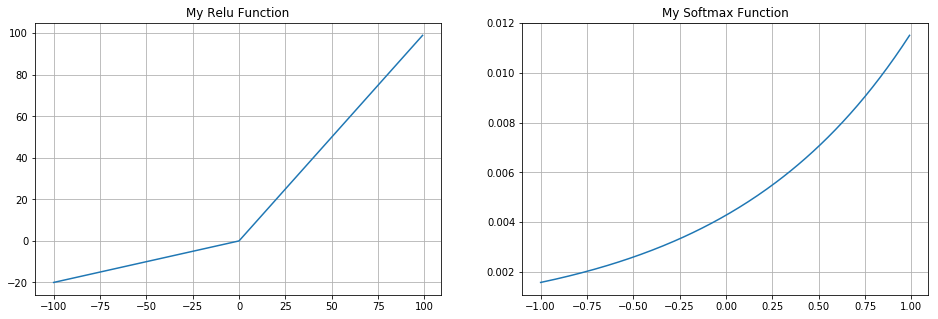

In [216]:
fig,ax = plt.subplots(ncols=2,figsize=(16,5))
x = tf.range(-100,100,dtype=tf.float32)
sns.lineplot(x=x,y=my_relu(x),ax=ax[0])
ax[0].grid()
ax[0].title.set_text('My Relu Function')
x = tf.range(-1,1,delta=0.01,dtype=tf.float32)
sns.lineplot(x=x,y=my_softmax(x),ax=ax[1])
ax[1].grid()
ax[1].title.set_text('My Softmax Function')

In [8]:
class MyDenseLayer(keras.layers.Layer): # Custom Dense Layer Implementation
    def __init__(self,units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units=units
        self.activation = activation
    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
                                name='kernel',shape=[batch_input_shape[-1],self.units],
                                initializer=my_glorot_normal)
        self.bias = self.add_weight(name='bias', shape=[self.units], initializer='zeros')
        
    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)
    
    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])
    
    def get_config(self):
        base_config =super().get_config()
        return {**base_config,'units':self.units,'activation':keras.activations.serialize(self.activation)}

In [164]:
class CustomModel(tf.keras.Model):
    
    def __init__(self,n_layers,n_units,output_dim,**kwargs):
        super().__init__(**kwargs)
        self.n_layers = n_layers
        self.n_units = n_units
        self.output_dim = output_dim
        self.flat_layer = tf.keras.layers.Flatten()
        self.dense_layer1 = MyDenseLayer(n_units,activation=my_relu)
        self.norm_layer = MyNormalizationLayer()
        self.dense_layer = MyDenseLayer(n_units,activation=my_relu)
        self.out_layer = MyDenseLayer(self.output_dim,activation=my_softmax)
        
    def call(self,inputs):
        z = self.flat_layer(inputs)
        z = self.dense_layer1(z)
        for _ in  range(1 + self.n_layers):
            z = self.norm_layer(z)
            z = self.dense_layer(z)
        return self.out_layer(z)

In [165]:
# Reset Backemd and set Random Seed to make results reproduceable and comparable
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [166]:
model = CustomModel(10,128,10)
model.compile(optimizer='nadam',loss='sparse_categorical_crossentropy',metrics=['acc'])
#model.build((32,28,28))
#model.summary()

In [169]:
history = model.fit(X_train,y_train,batch_size=32,epochs=1,validation_split=0.2)

1500/1500 [==============================] - 16s 10ms/step - loss: 0.1518 - acc: 0.9559 - val_loss: 0.1291 - val_acc: 0.9622


In [170]:
# Evaluate the Model
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.1553 - acc: 0.9577


[0.15530084073543549, 0.9577000141143799]

### What to Expect in Future

<b><I>Just Like a model, there is always scope for improvements for us humans</I></b>

<h1><i>Stay Hungry, Stay Foolish </i></h1>